In [1]:
%matplotlib notebook
import numpy as np
from scipy.stats import kde
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import os
import shutil
import subprocess
from subprocess import Popen
import datetime
import matplotlib.pyplot as plt  # plotting
import xlrd

from decimal import Decimal

from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.stats import binned_statistic_2d

# make prefix for figure filenames
now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date

In [21]:
# membrane_path = '../actincme/pkl_files/'

# generally we only want to plot the first membrane object
membrane_object = 1

# set normal_directionality based on whether the normal_vector is pointing such that a similarly oriented filament would have an angle of 0 (1) or 180 (-1)

# membrane_path = '2018August_Tomo27/'
# # if the membrane object to plot is not 1
# membrane_object = 45
# normal_directionality = -1

# membrane_path = '2018_April_Tomo01/'
# normal_directionality = -1

membrane_path = '2018June_Tomo14_Early_Invagination/'
normal_directionality = 1

# membrane_path = '2018June_Tomo14_Late_Invagination/'
# normal_directionality = -1

# membrane_path = '2018June_Tomo26/'
# normal_directionality = -1 

# # NOTE 2018march does not have unbranched filaments
# membrane_path = '2018March/'
# normal_directionality = 1

# membrane_path = '2018November_32/'
# normal_directionality = -1

In [22]:
# branched filaments file
branched_filaments_file = []
unbranched_filaments_file = []
membranefilename = []
nogoplane_name = []

files_in_dir = os.listdir(membrane_path)
for file in files_in_dir:
    if 'Branched' in file and 'txt' in file:
        branched_filaments_file = file

for file in files_in_dir:
    if 'Unbranched' in file and 'txt' in file:
        unbranched_filaments_file = file
        
# membrane file

for file in files_in_dir:
    if "embrane" in file or "CoatedVesicle" in file:
        membranefilename = file

# Find unbranched filaments orientation file
for file in files_in_dir:
    if "rientation" in file and 'xls' in file:
        orientation_info_file = file

# find nogo file 
for file in files_in_dir:
    if "eference" in file and "lane.txt" in file:
        nogoplane_name = file
        
membranefilename

'Membrane_2018June_Tomo14_Early_Invagination.txt'

In [23]:
# read in the unbranched filament orientation file
excelfile = pd.read_excel(membrane_path+ orientation_info_file)

# branched filaments
actinfile1 = membrane_path+branched_filaments_file

# unbranched filaments
actinfile2 = membrane_path + unbranched_filaments_file

# nogo plane
nogoplane = membrane_path + nogoplane_name
# membrane
membranefile = membrane_path + membranefilename
excelfile

,Contour Number In Model,Plus-end,Minus-end,Average difference
0,87,4,1,0.16
1,97,3,1,0.10
2,104,3,1,0.33
3,105,1,13,0.39
4,115,1,5,0.29
...,...,...,...,...
84,504,1,7,0.29
85,505,1,4,0.28
86,506,5,1,0.23
87,512,1,5,-0.23


In [24]:
# more manual way of finding the filex

# # working_dir = os.curdir
# actinfile1 = '2018June_Tomo26/UnbranchedActin_2018June_Tomo26_CME_Invagination.txt'
# actinfile2 = '2018June_Tomo26/BranchedActin_2018June_Tomo26_CME_Invagination.txt'
# membranefile = '2018June_Tomo26/Membrane_2018June_Tomo26_CME_Invagination.txt'
# #TODO: add in excel file into the code 
# #excelfile = 'placeholder.txt'
# excelfile = pd.read_excel('2018June_Tomo26/UnbranchedFilamentOrientationInfo.xlsx')
# # c = open(membranefile,'r')
# # c.readlines()
# nogoplane = '2018June_Tomo26/Reference_Plane.txt'

In [25]:
data_xls = excelfile
data_xls

#Purpose: Fix differences between folders
if 'Contour Number In Model' in data_xls.columns:
    data_xls = data_xls.rename(columns = {'Contour Number In Model': 'Contour number in model'})

#Purpose: Read unbranched coords txt file into a dataframe which is returned.
def read_text_unbranched_coords(file, label = 'fil'):
    import pandas as pd
    ub_coordsfile =  open(file, 'r')
    coords = pd.read_table(ub_coordsfile, delim_whitespace=True)
    coords.columns = ['Contour number in model', 'X', 'Y', 'Z']
    return coords
# actinfile2 is unbranched filaments
ub_coords = read_text_unbranched_coords(actinfile2)


#Purpose: Merge unbranched coords txt file with dataframe from excel file
def merge_files(unbranched_coords, xls_to_df):
    data_xls = xls_to_df
    merged_ub_coords = data_xls.merge(unbranched_coords)
    merged_ub_coords['X_nm'], merged_ub_coords['Y_nm'], merged_ub_coords['Z_nm'] = 0.06*merged_ub_coords['X'], 0.06*merged_ub_coords['Y'], 0.06*merged_ub_coords['Z']
#   merged_ub_coords = merged_ub_coords[['Contour number in model','X','Y','Z','X_nm','Y_nm','Z_nm','Plus end point','Minus end point','Clear Result (0-1)', \
#               'Filament length (nm)','Comment']]
    return merged_ub_coords
ub_coords
print(ub_coords.columns)
print(data_xls.columns)
merged_df = merge_files(ub_coords, data_xls)
merged_df

#Purpose: Add tag to the merged df
plus_ends = {}
for index, row in merged_df.iterrows():
    if(row['Minus-end'] == 1):
        #print('ya')
        plus_ends[row['Contour number in model']] = 'last'
    else:
        plus_ends[row['Contour number in model']] = 'first'
list_of_ends = []
for index, row in merged_df.iterrows():
    if(plus_ends[row['Contour number in model']] == 'last'):
        list_of_ends += ['first']
    else:
        list_of_ends += ['last']
merged_df['minus end point'] = list_of_ends
merged_df.head(50)
merged_df= merged_df.rename(columns = {'Contour number in model':'contour'})
merged_df

#Purpose: Select certain columns from merged table only
selected = merged_df[['contour', 'X', 'Y', 'Z', 'minus end point']]
selected= selected.rename(columns = {'contour':'fil'})
selected_ub_coords = selected.set_index('fil')
selected_ub_coords

Index(['Contour number in model', 'X', 'Y', 'Z'], dtype='object')
Index(['Contour number in model', 'Plus-end', 'Minus-end',
       'Average difference'],
      dtype='object')


,X,Y,Z,minus end point
fil,,,,
87,1131,615,167,first
87,1149,635,159,first
87,1167,655,156,first
97,917,552,149,first
97,984,611,151,first
...,...,...,...,...
512,1002,652,275,last
512,1051,691,268,last
512,1086,724,260,last


In [26]:
#  read in text file
# for all txt filex

# for a particular txt file


def read_text(file, label='fil'):
    
    import pandas as pd
    coordinatesfile = open(file, 'r')
    
    coords_df = pd.read_table(coordinatesfile, delim_whitespace=True)
#     check if there is an 'object' and 'contour' column (membrane)
    if len(coords_df.columns)==4:
        coords_df.columns=[label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index([label])
    
    elif len(coords_df.columns)==5:
        coords_df.columns=['object', label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index(['object', label])
        
    else:
        print("unexpected number of columns!")
#     make multiindex
    coordinatesfile.close()
    return coords_df

actin1 = read_text(actinfile1)
actin2 = read_text(actinfile2)
membrane = read_text(membranefile, 'contour')
# membrane
branched_coords = actin1


In [27]:
#No-Go Plane Definition 
#Taken from here: https://stackoverflow.com/questions/53698635/how-to-define-a-plane-with-3-points-and-plot-it-in-3d
ngplane = read_text(nogoplane)
#ngplane.reset_index()
xvals = ngplane['X'].values
yvals = ngplane['Y'].values
zvals = ngplane['Z'].values
xs = []
ys = []
zs = []


# for i in range(int(xvals.size/2)):
#     a = i+1

# define a plane using any three points from the nogo text file

# e.g. use points 0, 1, and last (-1)

i = 0
j = 1
k =-1

points = [[xvals[i], yvals[i], zvals[i]],
          [xvals[j], yvals[j], zvals[j]], 
          [xvals[k], yvals[k], zvals[k]]]

p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

# calculate vectors between points 0 and 1 (and between 1 and 2)

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

# calcualte cross product

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

# normal vector as an array

point  = np.array(p0)
normal = np.array(u_cross_v)

d = -point.dot(normal)
xx, yy = np.meshgrid(range(10), range(10))

z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
# print(z)

# xs.append(xx)
# ys.append(yy)
# zs.append(z)


# define which mebmrane surface to plot
## object == 1 is the CCP


In [28]:
all_membranes = membrane.reset_index()
CCP = all_membranes[all_membranes['object']==membrane_object]


In [29]:
# # plot membrane

# # %matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=[16,8])
# ax=fig.add_subplot(111, projection='3d')

# for contourr in CCP['contour'].unique():
#     cur_contour = CCP[CCP['contour']==contourr]
#     ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3)

In [30]:
# # plot actin and membrane
# # %matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=[10,5])
# ax=fig.add_subplot(111, projection='3d')

# # all_membranes = membrane.reset_index()
# # CCP = all_membranes[all_membranes['object']==1]

# for filament in selected_ub_coords.index.unique():
#     cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3,)

# for filament in branched_coords.index.unique():
#     cur_filament = branched_coords[branched_coords.index==filament]
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3)

# for contourr in CCP['contour'].unique():
#     cur_contour = CCP[CCP['contour']==contourr]
#     ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')

# for i in range(int(xvals.size/2)):
#     ax.plot([xvals[i], xvals[i+1]],[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])
 


# # plot membrane
# # pit = membranes[membranes['contour']==1]
# # ax.plot(xs = pit['X'], ys=pit['Y'], zs = pit['Z'], linewidth=5)
# # ax.autoscale(enable=True,tight=True) 

# # plt.xlim([500,1400])
# # plt.ylim([350,950])
# # ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])


# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# Removing unbranched filaments from df based on no-go plane

In [31]:
#Distance between reference lines & filaments
selected_ub_coords
tagged_fil = []
for index, row in selected_ub_coords.iterrows():
    #line spans p to q and 'r' is the given point
    count = 0
    for i in range(int(xvals.size/2)):
        p = np.array([xvals[i], yvals[i], zvals[i]])
        q = np.array([xvals[i+1], yvals[i+1], zvals[i+1]])
        r = np.array([row.X, row.Y, row.Z])
        
        
        def t(p, q, r):
            x = p-q
            return np.dot(r-q, x)/np.dot(x, x)

        def d(p, q, r):
            return np.linalg.norm(t(p, q, r)*(p-q)+q-r)

        if(d(p, q, r) <10):
            count +=1
#             print(str(row.name))
#             print(count)
            tagged_fil.append(row.name) if row.name not in tagged_fil else tagged_fil
            
    #print(d(p, q, r))
tagged_fil
bb = selected_ub_coords.reset_index()
bb[~bb.fil.isin(tagged_fil)]

selected_ub_coords = bb[~bb.fil.isin(tagged_fil)]
selected_ub_coords= selected_ub_coords.set_index('fil')
selected_ub_coords

,X,Y,Z,minus end point
fil,,,,
87,1131,615,167,first
87,1149,635,159,first
87,1167,655,156,first
97,917,552,149,first
97,984,611,151,first
...,...,...,...,...
512,1002,652,275,last
512,1051,691,268,last
512,1086,724,260,last


In [32]:
branched_coords
tagged_fil = []
for index, row in branched_coords.iterrows():
    #line spans p to q and 'r' is the given point
    count = 0
    for i in range(int(xvals.size/2)):
        p = np.array([xvals[i], yvals[i], zvals[i]])
        q = np.array([xvals[i+1], yvals[i+1], zvals[i+1]])
        r = np.array([row.X, row.Y, row.Z])
        
        
        def t(p, q, r):
            x = p-q
            return np.dot(r-q, x)/np.dot(x, x)

        def d(p, q, r):
            return np.linalg.norm(t(p, q, r)*(p-q)+q-r)

        if(d(p, q, r) <10):
            count +=1
            print(str(row.name))
            print(count)
            tagged_fil.append(row.name) if row.name not in tagged_fil else tagged_fil
            
    #print(d(p, q, r))
tagged_fil
bb = branched_coords.reset_index()
bb[~bb.fil.isin(tagged_fil)]

selected_branched_coords = bb[~bb.fil.isin(tagged_fil)]
selected_branched_coords = selected_branched_coords.set_index('fil')
selected_branched_coords.head(15)

,X,Y,Z
fil,,,
45,1131,719,259
45,1115,703,254
47,1164,562,117
47,1128,593,140
47,1117,598,146
47,1106,607,153
47,1077,634,172
47,1028,675,203
48,1113,623,155


<IPython.core.display.Javascript object>


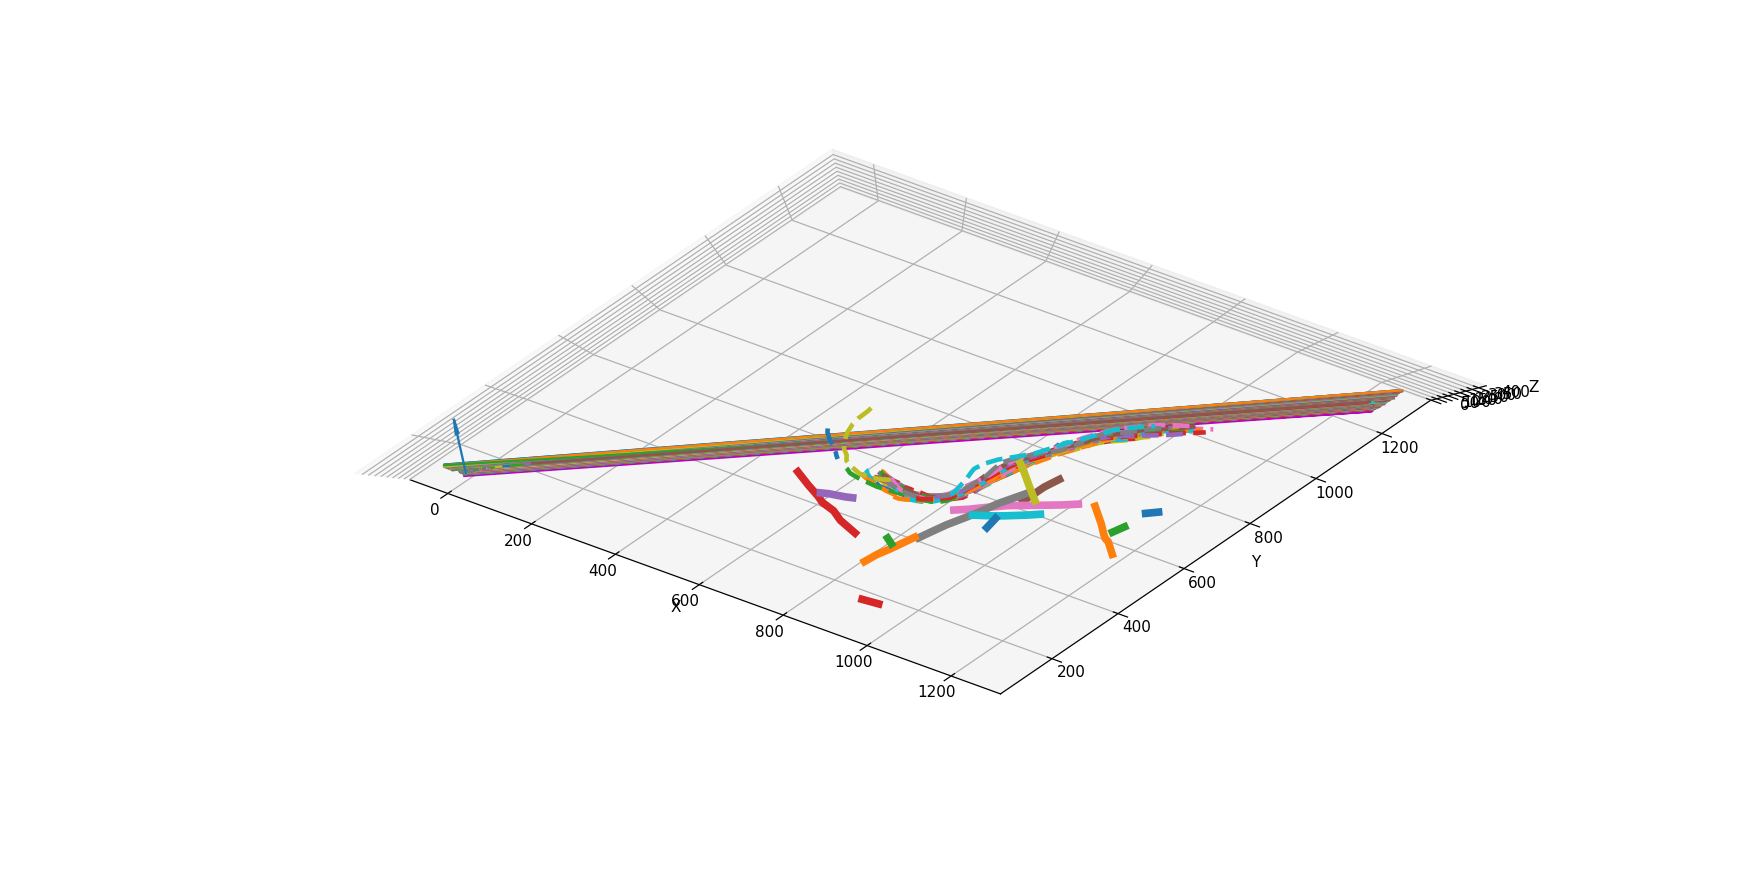

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

In [33]:
# plot the nogo lines, membrane contour, and the plane defined by three lines from the nogo file

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection='3d')

ax.plot(xs=[xvals[0], xvals[1], xvals[-1]],ys =[yvals[0], yvals[1], yvals[-1]], zs = [zvals[0], zvals[1], zvals[-1]],linewidth=4, color='m')
for i in range(int(xvals.size)-1):
    ax.plot(xs=[xvals[i], xvals[i+1]],ys =[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')

for filament in selected_branched_coords.index.unique():
    cur_filament = selected_branched_coords[selected_branched_coords.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])
    
#     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=5)

    
# ax.plot(xs = [x0, normal[0]], ys = [y0, normal[1]], zs = [z0, normal[2]], color="m")
unit_vector_1 = normal / np.linalg.norm(normal)
ax.quiver(x0,y0,z0,unit_vector_1[0],unit_vector_1[1],unit_vector_1[2], length=200)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')

# ax.plot(xs=[0,unit_vector_1[0]*500], ys=[0,unit_vector_1[1]*500], zs=[0,unit_vector_1[2]*500], linewidth=6, color = 'b')
# ax.plot(xs=[0,unit_vector_2[0]*500], ys=[0,unit_vector_2[1]*500], zs=[0,unit_vector_2[2]*500], linewidth=6, color = 'g')
# plt.xlim([0,2000])
# plt.ylim([-500,1500])
# ax.set_zlim([0, 200])

plt.show()

    

In [13]:
# optional: save figure
fig.savefig(membrane_path+'normal_orientation_plot.pdf', format='pdf')
fig.savefig(membrane_path+'normal_orientation_plot.png', format='png')

# calculate directionality of filaments
## branched filaments here

In [34]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []

dot_products = []
relative_angles = []
normal_angles = []
relative_angles_90 = []
normal_vector = normal


for filament in selected_branched_coords.index.unique():
    cur_filament = selected_branched_coords[selected_branched_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))
    
    fil_vector = (deltaxx, deltayy, deltazz)
    
#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
# We set the normal_directionality value (1 or -1) near the top of the notebook when setting the folder name
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)*normal_directionality
    
#     relative_angle is the relative angle between the normal vector and the filament vector
#   starts at 0 and ends at 180

#     relative_angle = np.degrees((np.pi)-np.arccos(dot_product)) 
    relative_angle = np.degrees(np.arccos(dot_product))
    
#     relative_angle_90 starts at +90 and ends at -90 degrees
    relative_angle_90 = -np.degrees((np.arccos(dot_product)-(np.pi)/2)) 
   
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['relative_angle_90'] = relative_angle_90
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
branched_filaments_df = pd.concat(all_filaments)
branched_filaments_df

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,X,Y,Z,ydir,zdir,length,relative_angle,relative_angle_90,dot_product
fil,,,,,,,,,
45,1131,719,259,-45.570713,12.894757,22.405357,95.113228,-5.113228,-0.089124
45,1115,703,254,-45.570713,12.894757,22.405357,95.113228,-5.113228,-0.089124
47,1164,562,117,39.592306,-29.015119,177.304822,15.057418,74.942582,0.965666
47,1128,593,140,39.592306,-29.015119,177.304822,15.057418,74.942582,0.965666
47,1117,598,146,39.592306,-29.015119,177.304822,15.057418,74.942582,0.965666
47,1106,607,153,39.592306,-29.015119,177.304822,15.057418,74.942582,0.965666
47,1077,634,172,39.592306,-29.015119,177.304822,15.057418,74.942582,0.965666
47,1028,675,203,39.592306,-29.015119,177.304822,15.057418,74.942582,0.965666
48,1113,623,155,75.608399,-12.430124,27.874720,53.626209,36.373791,0.593051


In [35]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # ax.plot(xs=[0,unit_vector_1[0]*500], ys=[0,unit_vector_1[1]*500], zs=[0,unit_vector_1[2]*500], linewidth=6, color = 'b')
# # ax.plot(xs=[0,unit_vector_2[0]*500], ys=[0,unit_vector_2[1]*500], zs=[0,unit_vector_2[2]*500], linewidth=6, color = 'g')
# # ax.quiver(unit_vector_1[0], unit_vector_1[1], unit_vector_1[2],unit_vector_1[0], unit_vector_1[1], unit_vector_1[2])
# ax.quiver(0,0,0,unit_vector_1[0], unit_vector_1[1], unit_vector_1[2], length=.1)

# plt.figure()


# Calculate orientation of unbranched Filaments


In [36]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []

dot_products = []
relative_angles = []
normal_angles = []
relative_angles_90 = []
normal_vector = normal

selected_ub_coords['min_end'] = selected_ub_coords['minus end point']
selected_ub_coords.min_end.replace(('first', 'last'), (1, -1), inplace=True)

for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z
#     calculate a directionality: -1 for minus end is the last point
#  and +1 for minus end is the first point
# this assumes that the orientation value is the same for all points on the filament

    ub_directionality = cur_filament.min_end.mean()
    
    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))
    
    fil_vector = (deltaxx, deltayy, deltazz)
    
#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
# We set the normal_directionality value (1 or -1) near the top of the notebook when setting the folder name
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)*normal_directionality*ub_directionality
    
#     relative_angle is the relative angle between the normal vector and the filament vector
#   starts at 0 and ends at 180

#     relative_angle = np.degrees((np.pi)-np.arccos(dot_product)) 
    relative_angle = np.degrees(np.arccos(dot_product))
    
#     relative_angle_90 starts at +90 and ends at -90 degrees
    relative_angle_90 = -np.degrees((np.arccos(dot_product)-(np.pi)/2)) 
   
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['relative_angle_90'] = relative_angle_90
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
ub_filaments_df = pd.concat(all_filaments)
ub_filaments_df

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,X,Y,Z,minus end point,min_end,ydir,zdir,length,relative_angle,relative_angle_90,dot_product
fil,,,,,,,,,,,
87,1131,615,167,first,1,48.256561,11.840431,53.609701,87.282910,2.717090,0.047404
87,1149,635,159,first,1,48.256561,11.840431,53.609701,87.282910,2.717090,0.047404
87,1167,655,156,first,1,48.256561,11.840431,53.609701,87.282910,2.717090,0.047404
97,917,552,149,first,1,39.578742,-2.988153,172.647039,92.177583,-2.177583,-0.037997
97,984,611,151,first,1,39.578742,-2.988153,172.647039,92.177583,-2.177583,-0.037997
...,...,...,...,...,...,...,...,...,...,...,...
512,1002,652,275,last,-1,37.486459,5.821464,285.914323,83.830245,6.169755,0.107475
512,1051,691,268,last,-1,37.486459,5.821464,285.914323,83.830245,6.169755,0.107475
512,1086,724,260,last,-1,37.486459,5.821464,285.914323,83.830245,6.169755,0.107475


# Orientation Plot Stuff From Other Notebook

<IPython.core.display.Javascript object>


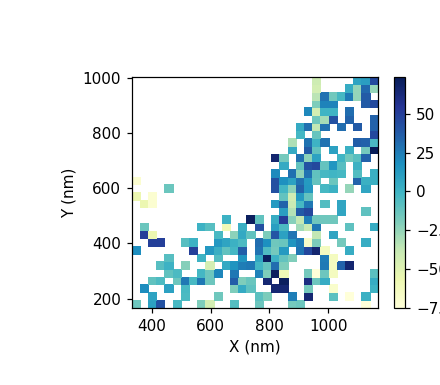

In [37]:
# branch angle  heat map XZ

fig = plt.figure(figsize=[4,3.5])
ax = fig.add_axes([0.3, 0.2, 0.7, 0.6])

plt.cm.get_cmap('PiYG')
# plt.set_cmap('PiYG')
plt.set_cmap('YlGnBu')



x = ub_filaments_df['X']
y = ub_filaments_df['Y']

color = ub_filaments_df['relative_angle_90']

bin_means, xedges, yedges, binnumbers = binned_statistic_2d(x, y, color, 
  bins=30, statistic='mean')
bin_means = np.flipud(np.rot90(bin_means))

# bin_means = bin_means/len(runs)/len(times)

plt.pcolormesh(xedges, yedges, bin_means)

plt.colorbar(label = 'Axial orientation')
plt.xlabel('X (nm)')
plt.ylabel('Y (nm)')
# plt.ylim([-200,0])
plt.show()

In [38]:
# take just the unique filaments (not every coordinate)
branched_filaments_unique = branched_filaments_df.groupby('fil').first()
ub_filaments_unique = ub_filaments_df.groupby('fil').first()


In [39]:
# save
branched_filaments_unique.to_csv(membrane_path+'branched_filaments_angles.csv')
ub_filaments_unique.to_csv(membrane_path+'unbranched_filaments_angles.csv')
# could just save the unique filaments and not every model point
branched_filaments_unique.head(10)

,X,Y,Z,ydir,zdir,length,relative_angle,relative_angle_90,dot_product
fil,,,,,,,,,
45,1131,719,259,-45.570713,12.894757,22.405357,95.113228,-5.113228,-0.089124
47,1164,562,117,39.592306,-29.015119,177.304822,15.057418,74.942582,0.965666
48,1113,623,155,75.608399,-12.430124,27.874720,53.626209,36.373791,0.593051
49,507,473,153,-27.412702,9.765714,247.612601,160.038081,-70.038081,-0.939920
50,587,437,145,17.888863,7.431191,61.854668,115.582342,-25.582342,-0.431808
51,909,617,200,85.627919,-1.767158,97.283092,47.455869,42.544131,0.676158
52,826,522,249,39.895230,25.127980,226.072997,97.388250,-7.388250,-0.128592
53,901,651,167,-74.185682,-15.342665,249.441376,116.200296,-26.200296,-0.441510
54,927,632,166,41.289088,10.329537,139.423814,23.755206,66.244794,0.915275


In [145]:
# # hsv 75% colormap
# # https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
# # %matplotlib inline
# import matplotlib.colors as colors

# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap

# cmap = plt.get_cmap('hsv')
# new_cmap = truncate_colormap(cmap, 0, 0.75)

In [40]:
# choose a colormap

import matplotlib.colors as colors
import matplotlib.cm as cmx

# colorss = cm = plt.get_cmap('bwr') 
# colorss = cm = plt.get_cmap('viridis') 
colorss = cm = plt.get_cmap('coolwarm') 


# colorss = cm = plt.get_cmap(new_cmap)
 
# cNorm  = colors.Normalize(vmin=0, vmax=values[-1])

# cNorm  = colors.Normalize(vmin=-90, vmax=90)

cNorm  = colors.Normalize(vmin=0, vmax=180)

# set colorlim to [-1 to 1]
# cNorm  = colors.Normalize(vmin=-1, vmax=1)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colorss)
print(scalarMap.get_clim())


(0.0, 180.0)


# plot unbranched filaments

<IPython.core.display.Javascript object>


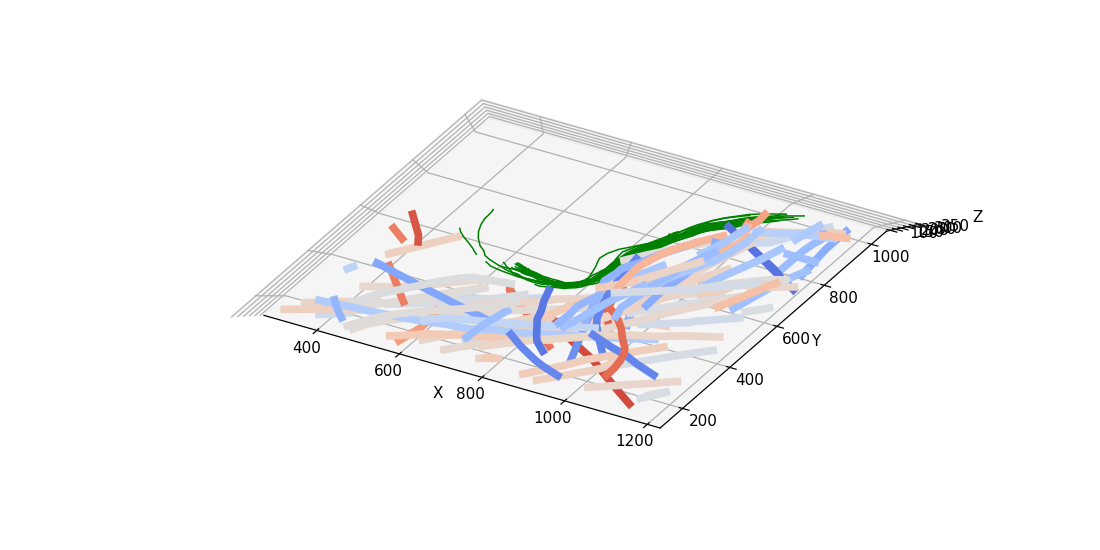

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/a

Text(0.5, 0, 'Z')

In [41]:
# color code angles
# %matplotlib inline
from matplotlib import cm

# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
# ax=fig.add_subplot(111, projection='3d')
ax=fig.gca(projection='3d')


# membrane

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], color='g', linewidth=1)

# for filament in all_filaments_df.index.unique():
#     cur_filament = all_filaments_df[all_filaments_df.index==filament]
# #     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
# #     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])
    
# #     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)


for filament in ub_filaments_df.index.unique():
    cur_filament = ub_filaments_df[ub_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])    
#     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)

    

# for filament in ub_all_filaments_df.index.unique():
#     cur_filament = ub_all_filaments_df[ub_all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])
# cbar = fig.colorbar(colorVal,ax=ax)
# fig.colorbar(p)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



In [39]:
# save figure
fig.savefig(membrane_path+'unbranched_filament_plot.pdf', format='pdf')
fig.savefig(membrane_path+'unbranched_filament_plot.png', format='png')

# Plot branched filament orientations 

<IPython.core.display.Javascript object>


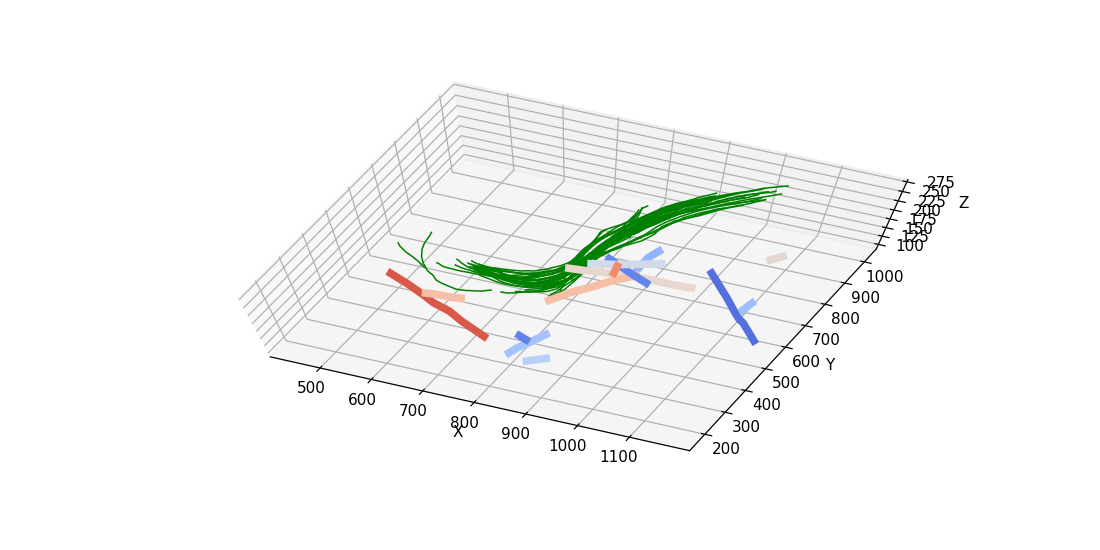

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

Text(0.5, 0, 'Z')

In [42]:
# color code angles
# %matplotlib inline
from matplotlib import cm

# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
# ax=fig.add_subplot(111, projection='3d')
ax=fig.gca(projection='3d')


# membrane

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], color='g', linewidth=1)

for filament in branched_filaments_df.index.unique():
    cur_filament = branched_filaments_df[branched_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])
    
#     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)


# for filament in ub_filaments_df.index.unique():
#     cur_filament = ub_filaments_df[ub_filaments_df.index==filament]
# #     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
# #     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])    
# #     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)

    

# for filament in ub_all_filaments_df.index.unique():
#     cur_filament = ub_all_filaments_df[ub_all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])
# cbar = fig.colorbar(colorVal,ax=ax)
# fig.colorbar(p)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [20]:
# save figure
fig.savefig(membrane_path+'branched_filament_plot.pdf', format='pdf')
fig.savefig(membrane_path+'branched_filament_plot.png', format='png')

# Additional plots to mess around with 

In [18]:
# plt.figure()
# plt.hist(relative_angles)
# # plt.show()

In [37]:
# # just to check the relationship between dot product and angle

# dots = np.arange(-1,1.1,0.1)
# # thetas = 
# # thetas = np.degrees((np.pi)-np.arccos(dots)) 
# thetas = np.degrees(np.arccos(dots))

# thetas_90 = -np.degrees((np.arccos(dots)-(np.pi)/2)) 

# fig = plt.figure()
# ax=fig.add_subplot(111)
# ax.plot(dots,thetas)
# plt.xlim([-1,1])
# plt.ylim([0,180])
# # plt.ylim([-90,90])
# plt.xlabel('dot product')
# plt.ylabel('relative angle')


# end! the rest is just draft material

In [ ]:
# # arrowheads??
# # https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
# import numpy as np
# from numpy import *
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         FancyArrowPatch.draw(self, renderer)


In [ ]:
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

# a = Arrow3D(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], mutation_scale=20, 
#                 lw=3, arrowstyle="-|>", color="r")
# ax.add_artist(a)